In [1]:
# All imports will be here:
import pandas as pd
import numpy as np
from utils import import_and_transform
from utils import evaluate_model
from utils import aggregate
from utils import evaluate_model_log_reg
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


In [ ]:
from utils import import_and_transform_v3

from utils import aggregate_v3
raw_data = pd.read_parquet("Data/train.parquet")
user_data = import_and_transform_v3(raw_data)
user_data = aggregate_v3(user_data)

features_to_drop = [
    'registration',
    'ts_min',
    'ts_max',
]
user_data.set_index('userId', inplace=True)
user_data.drop(columns = features_to_drop, inplace = True)

# SPlit in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    user_data.drop(columns = ['churned']),
    user_data['churned'],
    test_size = 0.2,
    random_state = 42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Using Dataframe
Processed 19140 users
Churn rate: 22.31%


In [3]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")
print(f"Training churn rate: {y_train.mean():.2%}")

# Define parameter grid for XGBoost
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create base XGBoost classifier
xgb_base = xgb.XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

# GridSearchCV
grid_search_xgb = GridSearchCV(
    xgb_base,
    param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2  # Shows progress
)

print("\n🔍 Starting XGBoost Grid Search (this may take 5-10 minutes)...")
grid_search_xgb.fit(X_train_scaled, y_train)

print(f"\n✅ Grid Search Complete!")
print(f"Best params: {grid_search_xgb.best_params_}")
print(f"Best CV ROC-AUC score: {grid_search_xgb.best_score_:.4f}")

# Get the best model
best_xgb = grid_search_xgb.best_estimator_

# Evaluate on test set
y_pred_xgb = best_xgb.predict(X_test_scaled)
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]

print("\n=== XGBoost Test Set Performance (default threshold 0.5) ===")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Scale pos weight: 3.48
Training churn rate: 22.34%

🔍 Starting XGBoost Grid Search (this may take 5-10 minutes)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Grid Search Complete!
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV ROC-AUC score: 0.8902

=== XGBoost Test Set Performance (default threshold 0.5) ===
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      2978
           1       0.58      0.78      0.67       850

    accuracy                           0.83      3828
   macro avg       0.76      0.81      0.77      3828
weighted avg       0.85      0.83      0.84      3828

ROC-AUC Score: 0.8870

Confusion Matrix:
[[2506  472]
 [ 190  660]]


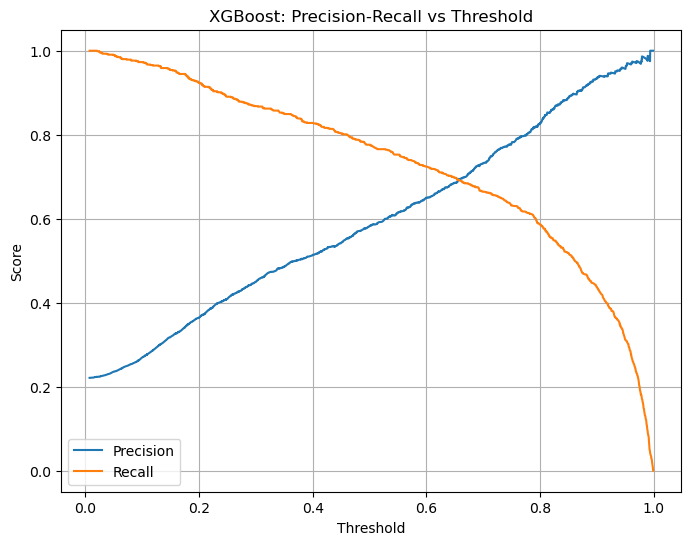


Optimal threshold for 80% recall: 0.460

=== XGBoost with Optimal Threshold (0.460) ===
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      2978
           1       0.55      0.80      0.65       850

    accuracy                           0.81      3828
   macro avg       0.74      0.81      0.76      3828
weighted avg       0.85      0.81      0.82      3828


Confusion Matrix:
[[2430  548]
 [ 170  680]]


In [4]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.title('XGBoost: Precision-Recall vs Threshold')
plt.show()

# Find threshold for 80% recall
target_recall = 0.8
idx = np.argmin(np.abs(recall - target_recall))
optimal_threshold_xgb = thresholds[idx]
print(f"\nOptimal threshold for {target_recall:.0%} recall: {optimal_threshold_xgb:.3f}")

# Apply optimal threshold
y_pred_xgb_optimal = (y_proba_xgb >= optimal_threshold_xgb).astype(int)

print(f"\n=== XGBoost with Optimal Threshold ({optimal_threshold_xgb:.3f}) ===")
print(classification_report(y_test, y_pred_xgb_optimal))
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_optimal))


=== Top 10 Most Important Features ===
                       feature  importance
8                  days_active    0.321411
10            sessions_per_day    0.231642
2                 num_sessions    0.095961
12               songs_per_day    0.077076
7                 total_length    0.048356
13       avg_listening_per_day    0.046646
9            membership_length    0.037790
1                        level    0.026885
6               unique_artists    0.022255
3          max_item_in_session    0.019264
14            artist_diversity    0.017139
4   avg_session_length_seconds    0.016226
11           songs_per_session    0.014922
5             num_songs_played    0.014489
0                       gender    0.009937


<Figure size 1000x600 with 0 Axes>

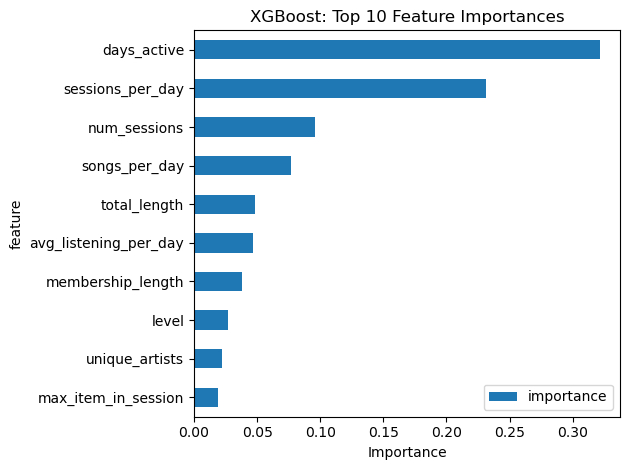

In [5]:
# Show most important features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 10 Most Important Features ===")
print(feature_importance)

# Plot
plt.figure(figsize=(10, 6))
feature_importance.head(10).plot(x='feature', y='importance', kind='barh')
plt.xlabel('Importance')
plt.title('XGBoost: Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Prepare test data
test_data = import_and_transform("Data/test.parquet")
test_data = aggregate(test_data)
test_data.set_index('userId', inplace=True)
test_data.drop(columns=features_to_drop, inplace=True)
test_data.drop(columns=['churned'], inplace=True)

test_data_scaled = pd.DataFrame(
    scaler.transform(test_data),
    index=test_data.index,
    columns=test_data.columns
)

# Generate XGBoost submission
evaluate_model_log_reg(
    best_xgb, 
    test_data_scaled, 
    threshold=0.5,
    file_out='submission_xgboost.csv'
)

Importing parquet file
Processed 2904 users
Churn rate: 0.00%
Normal predictions: 12.33% churn
Flipped predictions: 87.67% churn

Submit 'submission_FLIPPED.csv' to Kaggle!


In [12]:
test_raw = pd.read_parquet("Data/test.parquet")
print("=== RAW TEST DATA INSPECTION ===")
print(f"Shape: {test_raw.shape}")
print(f"\nColumns: {test_raw.columns.tolist()}")
print(f"\nFirst few rows:")
print(test_raw.head(10))
print(f"\nUnique pages in test:")
print(test_raw['page'].value_counts())
print(f"\nDoes test have 'Cancellation Confirmation'? {('Cancellation Confirmation' in test_raw['page'].values)}")
print(f"\nNumber of unique users: {test_raw['userId'].nunique()}")

=== RAW TEST DATA INSPECTION ===
Shape: (4393179, 19)

Columns: ['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts', 'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent', 'method', 'length', 'song', 'artist', 'time', 'registration']

First few rows:
      status gender firstName level lastName   userId             ts  \
7        200      M  Jonathan  free   Martin  1465194  1538352006000   
54       200      M  Jonathan  free   Martin  1465194  1538352028000   
477      200      M  Jonathan  free   Martin  1465194  1538352256000   
1170     200      M  Jonathan  free   Martin  1465194  1538352611000   
1552     200      M  Jonathan  free   Martin  1465194  1538352802000   
1596     200      M  Jonathan  free   Martin  1465194  1538352825000   
2105     200      M  Jonathan  free   Martin  1465194  1538353077000   
2581     200      M  Jonathan  free   Martin  1465194  1538353316000   
3355     200      M  Jonathan  free   Martin  1465194  153835371800

In [13]:
# Load raw train data
train_raw = pd.read_parquet("Data/train.parquet")

print("\n=== RAW TRAIN DATA INSPECTION ===")
print(f"Shape: {train_raw.shape}")
print(f"\nUnique pages in train:")
print(train_raw['page'].value_counts())
print(f"\nNumber of unique users: {train_raw['userId'].nunique()}")


=== RAW TRAIN DATA INSPECTION ===
Shape: (17499636, 19)

Unique pages in train:
page
NextSong                     14291433
Thumbs Up                      789391
Home                           645259
Add to Playlist                409606
Roll Advert                    284837
Add Friend                     262147
Logout                         204700
Thumbs Down                    164964
Downgrade                      124248
Settings                       101191
Help                            89035
Upgrade                         37696
About                           33117
Save Settings                   20370
Error                           17294
Submit Upgrade                  11381
Submit Downgrade                 4425
Cancellation Confirmation        4271
Cancel                           4271
Name: count, dtype: int64

Number of unique users: 19140


In [7]:
# Find which threshold gives ~22% predicted churn
y_proba_test = best_xgb.predict_proba(test_data_scaled)[:, 1]

print("=== Testing Different Thresholds ===")
for threshold in [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
    y_pred = (y_proba_test >= threshold).astype(int)
    predicted_churn_rate = y_pred.mean()
    print(f"Threshold {threshold:.2f}: {predicted_churn_rate:.2%} predicted churn")
    
    # Generate submission for thresholds close to 22%
    if 0.18 <= predicted_churn_rate <= 0.26:
        evaluate_model_log_reg(
            best_xgb, 
            test_data_scaled, 
            threshold=threshold,
            file_out=f'submission_xgb_t{int(threshold*100)}.csv'
        )

=== Testing Different Thresholds ===
Threshold 0.15: 55.10% predicted churn
Threshold 0.20: 41.08% predicted churn
Threshold 0.25: 30.17% predicted churn
Threshold 0.30: 24.62% predicted churn
Submission saved to submission_xgb_t30.csv
Predicted churn rate: 24.62%
Threshold 0.35: 20.18% predicted churn
Submission saved to submission_xgb_t35.csv
Predicted churn rate: 20.18%
Threshold 0.40: 16.98% predicted churn
Threshold 0.45: 14.57% predicted churn
Threshold 0.50: 12.33% predicted churn


In [8]:
print("=" * 80)
print("FEATURE DISTRIBUTION COMPARISON")
print("=" * 80)

# Check the most important features
important_features = ['days_active', 'num_sessions', 'membership_length']

for feature in important_features:
    print(f"\n{feature}:")
    print(f"  Train mean: {X_train[feature].mean():.2f}")
    print(f"  Test mean:  {test_data[feature].mean():.2f}")
    print(f"  Ratio (test/train): {test_data[feature].mean() / X_train[feature].mean():.2f}x")

FEATURE DISTRIBUTION COMPARISON

days_active:
  Train mean: 31.24
  Test mean:  39.07
  Ratio (test/train): 1.25x

num_sessions:
  Train mean: 10.90
  Test mean:  61.31
  Ratio (test/train): 5.63x

membership_length:
  Train mean: 73.64
  Test mean:  78.57
  Ratio (test/train): 1.07x


In [9]:
print("\n" + "=" * 80)
print("PROBABILITY ANALYSIS")
print("=" * 80)

y_proba_train = best_xgb.predict_proba(X_train_scaled)[:, 1]
y_proba_test_kaggle = best_xgb.predict_proba(test_data_scaled)[:, 1]

print("\nTrain probabilities:")
print(f"  Mean: {y_proba_train.mean():.3f}")
print(f"  Median: {np.median(y_proba_train):.3f}")
print(f"  % above 0.5: {(y_proba_train > 0.5).mean():.2%}")

print("\nTest (Kaggle) probabilities:")
print(f"  Mean: {y_proba_test_kaggle.mean():.3f}")
print(f"  Median: {np.median(y_proba_test_kaggle):.3f}")
print(f"  % above 0.5: {(y_proba_test_kaggle > 0.5).mean():.2%}")

print("\n⚠️ If test probabilities are MUCH LOWER than train:")
print("   → Your model thinks test users are less likely to churn")
print("   → But Kaggle labels might disagree!")


PROBABILITY ANALYSIS

Train probabilities:
  Mean: 0.361
  Median: 0.232
  % above 0.5: 28.71%

Test (Kaggle) probabilities:
  Mean: 0.234
  Median: 0.167
  % above 0.5: 12.33%

⚠️ If test probabilities are MUCH LOWER than train:
   → Your model thinks test users are less likely to churn
   → But Kaggle labels might disagree!


In [10]:
# Sometimes the model learns the opposite pattern
# This is just a test - don't submit this!
y_pred_flipped = 1 - (y_proba_test_kaggle >= 0.5).astype(int)
print(f"\nIf we FLIP predictions: {y_pred_flipped.mean():.2%} would be churned")
print("(This is just diagnostic - tells us if model learned opposite pattern)")


If we FLIP predictions: 87.67% would be churned
(This is just diagnostic - tells us if model learned opposite pattern)
